# PCA & 군집분석


## 라이브러리 임포트


In [1]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
# Warning 무시
warnings.filterwarnings('ignore', category=UserWarning)

# Seaborn 테마 설정
sns.set_theme(style='whitegrid')

# matplotlib 한글 폰트 설정
os.system('rm -rf ~/.cache/matplotlib')
os.system('fc-cache -fv')

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

Font directories:
	/System/Library/Assets/com_apple_MobileAsset_Font3
	/System/Library/Assets/com_apple_MobileAsset_Font4
	/System/Library/Fonts
	/Library/Fonts
	/Users/registry/Library/Fonts
	/System/Library/AssetsV2/com_apple_MobileAsset_Font7
	/Users/registry/.local/share/fonts
	/usr/local/share/fonts
	/usr/share/fonts
	/Users/registry/.fonts
	/System/Library/Fonts/Supplemental
	/System/Library/AssetsV2/com_apple_MobileAsset_Font7/0818d874bf1d0e24a1fe62e79f407717792c5ee1.asset
	/System/Library/AssetsV2/com_apple_MobileAsset_Font7/0ab217c39c45c7c6acaddfa199fd32c55a7b4a19.asset
	/System/Library/AssetsV2/com_apple_MobileAsset_Font7/10b097deccb3c6126d986e24b1980031ff7399da.asset
	/System/Library/AssetsV2/com_apple_MobileAsset_Font7/12cc699be28fb04f3e3c4969a0378a87b920b174.asset
	/System/Library/AssetsV2/com_apple_MobileAsset_Font7/157acc4d862730d6d5beaa943546f80a71948c7b.asset
	/System/Library/AssetsV2/com_apple_MobileAsset_Font7/18189590ed3a5f46cef20ed4d1cec2611dca13ff.asset
	/System/L

## 데이터 로드 및 정제


In [4]:
# 데이터 로드
df1 = pd.read_csv('../data/cluster/ml_data_1.csv', index_col=0)
df2 = pd.read_csv('../data/cluster/ml_data_2.csv', index_col=0)

### 데이터 병합


In [5]:
# 데이터 병합
df = pd.merge(df1, df2, left_on='상권', right_on='상권')
df = df.dropna()

# 2024년에 대한 칼럼 제거
df = df.loc[:, ~df.columns.str.startswith("2024")]
df.shape

(1377, 2397)

### Standard Scaling


In [6]:
selected_columns = df.iloc[:, 10:].copy()  # 기존 데이터 복사
additional_columns = df[['x좌표', 'y좌표']]  # 추가할 컬럼 선택

# 📌 새로운 데이터프레임 생성
df_concated = pd.concat([selected_columns, additional_columns], axis=1)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_concated)  # 표준화 적용
df_scaled = pd.DataFrame(df_scaled, columns=df_concated.columns)  # DataFrame 변환
df_scaled.shape

(1377, 2389)

## PCA


In [7]:
# 분기 리스트 생성
quarters = [f"{year}{q}" for year in range(2019, 2024) for q in range(1, 5)]

# 결과 저장 딕셔너리
results = {
    'pca': {},
    'loading': {},
    'variance': {}
}

def perform_pca_analysis(df_scaled, quarter, variance_threshold=0.85):
  # 해당 분기에 해당하는 컬럼 선택
  selected_columns = [col for col in df_scaled.columns if col.startswith(quarter)]

  if not selected_columns:
    return None

  # 데이터 선택
  X = df_scaled[selected_columns]

  # PCA 수행
  pca = PCA()
  X_pca = pca.fit_transform(X)

  # 설명된 분산 비율 계산
  explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

  # 임계값을 넘는 최소 PC 개수 찾기
  num_components = np.argmax(explained_variance_ratio >= variance_threshold) + 1

  # 선택된 PC별 설명된 분산 비율 저장
  df_variance = pd.DataFrame({
      "PC": [f"PC{i+1}" for i in range(num_components)],
      "Explained_Variance": pca.explained_variance_ratio_[:num_components]
  })

  # 선택된 PC들만 사용하여 새로운 데이터프레임 생성
  df_pca = pd.DataFrame(
      X_pca[:, :num_components],
      columns=[f"PC{i+1}" for i in range(num_components)]
  )

  # 로딩값(주성분 계수) 계산
  loading_matrix = pca.components_[:num_components].T * np.sqrt(pca.explained_variance_[:num_components])

  # 로딩값 데이터프레임 생성
  df_loading = pd.DataFrame(
      loading_matrix,
      index=selected_columns,
      columns=[f"PC{i+1}_loading" for i in range(num_components)]
  )

  return {
      'pca': df_pca,
      'loading': df_loading,
      'variance': df_variance
  }

# 분기별로 PCA 수행
for quarter in quarters:
  result = perform_pca_analysis(df_scaled, quarter)

  if result:
    results['pca'][f"df_pca_{quarter}"] = result['pca']
    results['loading'][f"df_loading_{quarter}"] = result['loading']
    results['variance'][f"df_variance_{quarter}"] = result['variance']

# 결과를 전역 변수로 등록
for category, category_results in results.items():
  globals().update(category_results)

### 매출에 대한 우선분석에 대한 근거 확인


- PC1에서 매출에 해당하는 변수개수를 확인후 출력


In [8]:
def count_keyword_in_pc1_loadings(start_year=2019, end_year=2024, keyword="매출", top_n=20):
  # 결과를 저장할 데이터프레임 생성
  total_df = pd.DataFrame(index=range(top_n))

  # 각 분기별 데이터프레임 처리
  for year in range(start_year, end_year):
    for quarter in range(1, 5):
      df_name = f"df_loading_{year}{quarter}"

      if df_name in globals():  # 존재하는 데이터프레임만 처리
        # 로딩값 데이터프레임 가져오기
        df = globals()[df_name].copy()

        # PC1 로딩값 기준으로 내림차순 정렬
        df = df.sort_values(by='PC1_loading', ascending=False)

        # 상위 n개 변수 선택
        df = df.reset_index().head(top_n)

        # 결과 데이터프레임에 컬럼 추가
        col_name = f"{year}{quarter}_PC1"
        total_df[col_name] = pd.Series(df['index'].values[:top_n], index=range(top_n))

  # 각 컬럼에서 키워드가 포함된 셀 개수 카운트
  keyword_counts = total_df.apply(lambda col: col.astype(str).str.contains(keyword).sum())

  return keyword_counts

# 매출 키워드가 포함된 변수 개수 계산
store_counts = count_keyword_in_pc1_loadings(keyword="매출")

# 결과 출력
print(f"각 분기별 PC1 상위 20개 변수 중 '매출' 관련 변수 개수:")
print(store_counts)

각 분기별 PC1 상위 20개 변수 중 '매출' 관련 변수 개수:
20191_PC1    19
20192_PC1    20
20193_PC1    20
20194_PC1    19
20201_PC1    19
20202_PC1    18
20203_PC1    19
20204_PC1    19
20211_PC1    19
20212_PC1    19
20213_PC1    19
20214_PC1    19
20221_PC1    19
20222_PC1    19
20223_PC1    19
20224_PC1    19
20231_PC1    19
20232_PC1    19
20233_PC1    19
20234_PC1    19
dtype: int64


### 시각화


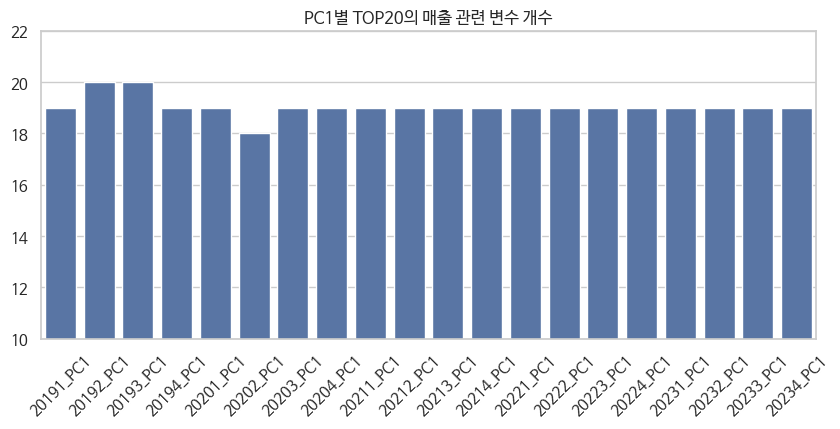

In [9]:
plt.figure(figsize=(10, 4))
sns.barplot(store_counts)
plt.xticks(rotation=45)
plt.title('PC1별 TOP20의 매출 관련 변수 개수')
plt.ylim((10, 22))
plt.show()

## 군집분석


### K-Means


In [10]:
# PCA 결과에 대한 KMeans 클러스터링 수행 함수
def perform_clustering(pca_df, n_clusters=4, random_state=42):
  # NaN 제거
  df_clean = pca_df.dropna()

  # 데이터 검증
  if df_clean.empty or df_clean.shape[0] < n_clusters:
    return None

  # KMeans 클러스터링 수행
  kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
  cluster_labels = kmeans.fit_predict(df_clean)

  # 클러스터링 결과 추가
  df_result = df_clean.copy()
  df_result["Cluster"] = cluster_labels

  return df_result

# 클러스터링 결과 저장 딕셔너리
final_cluster_results = {}

# globals()에서 df_pca_* 형태의 데이터프레임 찾기
pca_dfs = {key: value for key, value in globals().items() if key.startswith("df_pca_")}

# 각 PCA 데이터프레임에 대해 클러스터링 수행
for df_name, df_pca in pca_dfs.items():
  # "df_pca_"를 제거한 분기 이름 추출
  quarter_name = df_name.replace("df_pca_", "")

  try:
    # 클러스터링 수행
    cluster_result = perform_clustering(df_pca)

    # 결과가 있는 경우에만 저장
    if cluster_result is not None:
      final_cluster_results[f"df_4cluster_{quarter_name}"] = cluster_result
    else:
      print(f"{quarter_name}: 데이터가 부족하여 클러스터링을 수행할 수 없습니다.")
  except Exception as e:
    print(f"{quarter_name}: 클러스터링 오류 발생 - {str(e)}")

# 결과를 전역 변수로 등록 (필요한 경우)
globals().update(final_cluster_results)

# 생성된 클러스터 수 출력
print(f"총 {len(final_cluster_results)}개 분기의 클러스터링 완료")

총 20개 분기의 클러스터링 완료


In [11]:
# 클러스터링 결과를 개별 변수로 등록
globals().update(final_cluster_results)

# 생성된 데이터프레임 목록 확인
print("생성된 개별 데이터프레임 목록:", list(final_cluster_results.keys()))

생성된 개별 데이터프레임 목록: ['df_4cluster_20191', 'df_4cluster_20192', 'df_4cluster_20193', 'df_4cluster_20194', 'df_4cluster_20201', 'df_4cluster_20202', 'df_4cluster_20203', 'df_4cluster_20204', 'df_4cluster_20211', 'df_4cluster_20212', 'df_4cluster_20213', 'df_4cluster_20214', 'df_4cluster_20221', 'df_4cluster_20222', 'df_4cluster_20223', 'df_4cluster_20224', 'df_4cluster_20231', 'df_4cluster_20232', 'df_4cluster_20233', 'df_4cluster_20234']


In [12]:
# 각 클러스터링 결과 데이터프레임에 상권 정보 추가
for quarter_key, cluster_df in final_cluster_results.items():
  # 복사본 생성
  enriched_df = cluster_df.copy()

  # 상권 정보 추가
  enriched_df['상권'] = df['상권']

  # 새 변수명 생성 (df_4cluster_YYYYQ → cluster_df_YYYYQ)
  new_key = quarter_key.replace('df_4cluster_', 'cluster_df_')

  # 전역 변수로 등록
  globals()[new_key] = enriched_df

# 생성된 데이터프레임 개수 출력
processed_quarters = [k.replace('cluster_df_', '') for k in globals() if k.startswith('cluster_df_')]
print(f"총 {len(processed_quarters)}개 분기의 상권 정보가 추가된 클러스터링 데이터 생성 완료")

총 20개 분기의 상권 정보가 추가된 클러스터링 데이터 생성 완료


In [13]:
cluster_df_20191.head()

,PC1,PC2,PC3,PC4,Cluster,상권
0,-0.676738,3.134349,-0.529508,-0.822720,0,배화여자대학교(박노수미술관)
1,-0.540788,-0.766346,-0.242808,1.280549,1,세종마을음식문화거리(금천교시장)
2,-2.656878,-1.959457,-0.076684,0.203376,1,통인시장
3,-2.957838,-1.373154,0.118826,0.053731,1,동묘시장(동묘벼룩시장)
4,2.606929,-2.581391,-2.684357,0.627921,1,동대문문구완구거리(동대문문구완구시장)


### 군집 확인 및 저장


In [14]:
# 모든 분기의 클러스터 정보를 통합하는 데이터프레임 생성
total_df = pd.DataFrame()

# 각 클러스터링 결과 처리
for file_name in final_cluster_results.keys():
  # 클러스터링 결과 데이터프레임 가져오기
  cluster_df = globals()[file_name]

  # 클러스터 번호 재할당 (크기 기준 오름차순)
  cluster_counts = pd.DataFrame(cluster_df['Cluster'].value_counts()).sort_values(by='count')
  cluster_mapping = cluster_counts.reset_index().reset_index()[['index', 'Cluster']]

  # 원본 클러스터 번호를 재할당된 번호로 변경
  remapped_clusters = pd.merge(
      cluster_df[['Cluster']],
      cluster_mapping,
      on='Cluster'
  )['index'].rename('cluster')

  # 분기명으로 컬럼 이름 지정 (예: '20191_cluster')
  quarter_name = file_name[-5:]
  remapped_clusters.name = f'{quarter_name}_cluster'

  # 통합 데이터프레임에 추가
  total_df = pd.concat([total_df, remapped_clusters], axis=1)

# 상권 정보 추가
total_df['상권'] = df['상권']

# CSV 파일로 저장
total_df.to_csv('../data/cluster/cluster.csv')